In [3]:
import IPython
import librosa.display 
import librosa 
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, cross_val_score

sr = 44100

## データ読み込み
- dicomoは寝室・キッチン・リビングの順番

In [4]:
listMOBI = glob.glob('*mobi.WAV')
wav_listMOBI = sorted(listMOBI) #globはぐちゃぐちゃなので並べる
mobi_list = [i for i in range(11)]
for i in range(11):
    print("・", end="")
    mobi_list[i], sr = librosa.load(wav_listMOBI[i], sr=44100)
print("done!")

・・・・・・・・・・・done!


In [5]:
#import IPython.display
#IPython.display.Audio(wav_listMOBI[10])

In [6]:
dicomo_list = glob.glob("/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/*.wav" )

Dlist = [i for i in range(3)]
for i in range(3):
    print(".", end="")
    Dlist[i], sr = librosa.load(dicomo_list[i], sr=44100)
print("")
print("done!")

...
done!


In [7]:
dicomo_list

['/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/bedroom_2.wav',
 '/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/kitchen_2.wav',
 '/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/living_2.wav']

## 訓練データの整形
とりあえず4秒ずつ

In [8]:
#全体の長さはバラバラで良い
def arangeList4(a_list, total_time, one_time, sr):
    b_list = a_list[:] #スライスを使ってコピー
    for i in range(len(a_list)):
        if total_time*sr < len(a_list[i]):
            left = (len(a_list[i]) - total_time*sr) // 2
            b_list[i] = a_list[i][left :left + total_time*sr]
        
        else:
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sr))): #一つ当たりの数
            x = c_list[l][one_time*sr*k : one_time*sr*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [9]:
aranged = arangeList4(mobi_list, 120, 10, sr)
for i in range(11):
    print(len(aranged[i]))

6
12
12
12
12
12
12
12
12
12
12


## 行動ラベルを作成
0: 掃除機 .... 10: 声

In [10]:
label_list = []
for i in range(11):
    tmp = np.full(len(aranged[i]), i)
    label_list = np.append(label_list, tmp)
label_list.shape

(126,)

In [11]:
df_label_train = pd.DataFrame(label_list)
df_label_train.columns = ["action"]
#df_label_train

In [12]:
def makeTokucho_more(a_list):
    sr = 44100
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        print(i,"回目のループ開始！")
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            tokucho_librosa = []
        
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            FLATNESS = librosa.feature.spectral_flatness(y=y)
            ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
    
            
            tokucho_librosa.append(0) #ラベル
            tokucho1.append(tokucho_librosa)            
            print(".",end="")
        print("")
    print("done!!")
    return tokucho1

In [13]:
#feature = makeTokucho_new(aranged)
feature = makeTokucho_more(aranged)

0 回目のループ開始！
......
1 回目のループ開始！
............
2 回目のループ開始！
............
3 回目のループ開始！
............
4 回目のループ開始！
............
5 回目のループ開始！
............
6 回目のループ開始！
............
7 回目のループ開始！
............
8 回目のループ開始！
............
9 回目のループ開始！
............
10 回目のループ開始！
............
done!!


In [14]:
sound_features = ['FLATNESS',
                  'ZCR', 
                  'CENTROID',
                  'RMS',
                  'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

header = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            header += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(0,20):
            for kind in features:
                header += f" {name}{mfcc_number}_{kind}"
            
header += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header = header.split() #区切り文字で分割する

In [15]:
len(header)

101

In [16]:
df = pd.DataFrame(feature)
df.columns = header

len_all = len(aranged[0])+len(aranged[1])
len_liv = len(aranged[9])+len(aranged[10])
len_kit = len(aranged[3])+len(aranged[4])+len(aranged[5])+len(aranged[6])+len(aranged[7])+len(aranged[8])
len_bed = len(aranged[2])

df.iloc[:len_all, len(header)-1:] = 3
df.iloc[len_all:len_all+len_bed, len(header)-1:] = 2
df.iloc[len_all+len_bed:len_all+len_bed+len_kit, len(header)-1:] = 1
df.iloc[len_all+len_bed+len_kit:len_all+len_bed+len_kit+len_liv, len(header)-1:] = 0
df

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,0.040715,0.130226,0.007164,0.000381,0.146338,0.270996,0.061035,0.001641,5978.154352,7056.404976,...,24.201870,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3
1,0.044663,0.162874,0.003202,0.000477,0.182719,0.442383,0.009277,0.003979,6187.007176,8025.629980,...,21.014986,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3
2,0.051372,0.138668,0.010918,0.000415,0.207729,0.388672,0.077637,0.002723,6332.333621,7393.315702,...,16.981501,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3
3,0.039248,0.112485,0.009295,0.000382,0.163881,0.427734,0.069336,0.002651,6034.599744,7434.642289,...,22.289797,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3
4,0.063756,0.158518,0.013405,0.000835,0.215463,0.433105,0.080566,0.004592,6754.339799,8047.972582,...,20.879158,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.008231,0.096807,0.000031,0.000222,0.060403,0.359863,0.008301,0.003828,2845.424022,8213.236715,...,53.586926,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0
122,0.006171,0.120837,0.000015,0.000170,0.048449,0.367676,0.007812,0.002674,2405.711790,9425.164708,...,38.850502,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0
123,0.007102,0.116279,0.000026,0.000213,0.049973,0.321777,0.006348,0.002405,2549.670330,7465.310081,...,54.458698,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0
124,0.005369,0.087394,0.000030,0.000112,0.056970,0.334961,0.011719,0.003274,2630.491051,7455.022270,...,51.680428,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0


In [17]:
#MFCC[0]を除去
df = pd.concat([df, df_label_train], axis=1)
#df = df.drop(["MFCC0_mean", "MFCC0_max", "MFCC0_min", "MFCC0_var"],axis=1)
df

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label,action
0,0.040715,0.130226,0.007164,0.000381,0.146338,0.270996,0.061035,0.001641,5978.154352,7056.404976,...,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3,0.0
1,0.044663,0.162874,0.003202,0.000477,0.182719,0.442383,0.009277,0.003979,6187.007176,8025.629980,...,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3,0.0
2,0.051372,0.138668,0.010918,0.000415,0.207729,0.388672,0.077637,0.002723,6332.333621,7393.315702,...,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3,0.0
3,0.039248,0.112485,0.009295,0.000382,0.163881,0.427734,0.069336,0.002651,6034.599744,7434.642289,...,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3,0.0
4,0.063756,0.158518,0.013405,0.000835,0.215463,0.433105,0.080566,0.004592,6754.339799,8047.972582,...,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.008231,0.096807,0.000031,0.000222,0.060403,0.359863,0.008301,0.003828,2845.424022,8213.236715,...,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0,10.0
122,0.006171,0.120837,0.000015,0.000170,0.048449,0.367676,0.007812,0.002674,2405.711790,9425.164708,...,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0,10.0
123,0.007102,0.116279,0.000026,0.000213,0.049973,0.321777,0.006348,0.002405,2549.670330,7465.310081,...,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0,10.0
124,0.005369,0.087394,0.000030,0.000112,0.056970,0.334961,0.011719,0.003274,2630.491051,7455.022270,...,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0,10.0


In [18]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))
print("ありえない",len(df[df["label"]==5]))

リビング 24
キッチン 72
寝室 12
その他 18
ありえない 0


## テストデータの整形

In [19]:
def arangeList(a_list, cut_time, total_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    for j in range(len(b_list)):
        c_list[j] = b_list[j][:total_time*sampling_rate] #全体をtotal_time秒にする
        
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [20]:
arangedD = arangeList(Dlist, 10, 20*60, 10, sr)

In [21]:
def makeTokucho_more2(a_list):
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            tokucho_librosa = []
            
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            FLATNESS = librosa.feature.spectral_flatness(y=y)
            ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
            
           
            tokucho_librosa.append(0) #正解ラベル
            
            
            tokucho1.append(tokucho_librosa)            
        
            
        print(".", end="")
    print("done!")
    return tokucho1

In [22]:
D_feature = makeTokucho_more2(arangedD)

...done!


In [23]:
sound_features = ['FLATNESS',
                  'ZCR', 
                  'CENTROID',
                  'RMS',
                  'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

headerS = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            headerS += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(0,20):
            for kind in features:
                headerS += f" {name}{mfcc_number}_{kind}"
            
headerS += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
headerS = headerS.split() #区切り文字で分割する
#headerS

In [24]:
df_D = pd.DataFrame(D_feature)

In [25]:
df_D

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.022404,0.102959,0.002473,0.000222,0.059695,0.150391,0.002441,0.000524,5214.882323,7013.302543,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,0
1,0.021968,0.092731,0.002059,0.000194,0.060090,0.138184,0.003906,0.000512,5351.664910,6962.301155,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,0
2,0.020591,0.125100,0.000667,0.000210,0.059706,0.149902,0.003906,0.000557,5327.045811,7435.716999,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,0
3,0.020474,0.099834,0.000486,0.000215,0.058061,0.131836,0.003418,0.000587,5262.228145,7410.384750,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,0
4,0.021216,0.094637,0.003237,0.000186,0.060649,0.137695,0.011230,0.000482,5385.855216,7209.098015,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.020436,0.086027,0.002690,0.000145,0.057875,0.141113,0.011230,0.000403,5494.645295,7388.115795,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,0.021996,0.083603,0.002534,0.000172,0.063362,0.155762,0.013672,0.000498,5430.679982,7179.773458,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,0.021161,0.101203,0.002853,0.000197,0.059823,0.150879,0.003418,0.000540,5341.939204,7355.033194,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,0.021450,0.117408,0.002592,0.000186,0.060952,0.144043,0.003418,0.000473,5417.008793,7847.361761,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


In [26]:
df_D.columns = headerS
df_D

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,0.022404,0.102959,0.002473,0.000222,0.059695,0.150391,0.002441,0.000524,5214.882323,7013.302543,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,0
1,0.021968,0.092731,0.002059,0.000194,0.060090,0.138184,0.003906,0.000512,5351.664910,6962.301155,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,0
2,0.020591,0.125100,0.000667,0.000210,0.059706,0.149902,0.003906,0.000557,5327.045811,7435.716999,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,0
3,0.020474,0.099834,0.000486,0.000215,0.058061,0.131836,0.003418,0.000587,5262.228145,7410.384750,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,0
4,0.021216,0.094637,0.003237,0.000186,0.060649,0.137695,0.011230,0.000482,5385.855216,7209.098015,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.020436,0.086027,0.002690,0.000145,0.057875,0.141113,0.011230,0.000403,5494.645295,7388.115795,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,0.021996,0.083603,0.002534,0.000172,0.063362,0.155762,0.013672,0.000498,5430.679982,7179.773458,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,0.021161,0.101203,0.002853,0.000197,0.059823,0.150879,0.003418,0.000540,5341.939204,7355.033194,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,0.021450,0.117408,0.002592,0.000186,0.060952,0.144043,0.003418,0.000473,5417.008793,7847.361761,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


## rows　× columnsのrows÷7の値が↓に来ないといけない(630なら90)

In [27]:
df_D.columns = headerS
#正解のラベル

df_D.iloc[0:len(arangedD[0]),-1] = int(2)
df_D.iloc[len(arangedD[0]):len(arangedD[0]) + len(arangedD[1]),-1] = int(1)
df_D.iloc[len(arangedD[0]) + len(arangedD[1]):len(arangedD[0]) + len(arangedD[1]) + len(arangedD[2]),-1] = int(0)

df_D

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,0.022404,0.102959,0.002473,0.000222,0.059695,0.150391,0.002441,0.000524,5214.882323,7013.302543,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,2
1,0.021968,0.092731,0.002059,0.000194,0.060090,0.138184,0.003906,0.000512,5351.664910,6962.301155,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,2
2,0.020591,0.125100,0.000667,0.000210,0.059706,0.149902,0.003906,0.000557,5327.045811,7435.716999,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,2
3,0.020474,0.099834,0.000486,0.000215,0.058061,0.131836,0.003418,0.000587,5262.228145,7410.384750,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,2
4,0.021216,0.094637,0.003237,0.000186,0.060649,0.137695,0.011230,0.000482,5385.855216,7209.098015,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.020436,0.086027,0.002690,0.000145,0.057875,0.141113,0.011230,0.000403,5494.645295,7388.115795,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,0.021996,0.083603,0.002534,0.000172,0.063362,0.155762,0.013672,0.000498,5430.679982,7179.773458,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,0.021161,0.101203,0.002853,0.000197,0.059823,0.150879,0.003418,0.000540,5341.939204,7355.033194,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,0.021450,0.117408,0.002592,0.000186,0.060952,0.144043,0.003418,0.000473,5417.008793,7847.361761,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


In [28]:
#MFCC
#df_D = df_D.drop(["MFCC0_mean", "MFCC0_max", "MFCC0_min", "MFCC0_var"],axis=1)

In [29]:
df_D.head()

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,0.022404,0.102959,0.002473,0.000222,0.059695,0.150391,0.002441,0.000524,5214.882323,7013.302543,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,2
1,0.021968,0.092731,0.002059,0.000194,0.060090,0.138184,0.003906,0.000512,5351.664910,6962.301155,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,2
2,0.020591,0.125100,0.000667,0.000210,0.059706,0.149902,0.003906,0.000557,5327.045811,7435.716999,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,2
3,0.020474,0.099834,0.000486,0.000215,0.058061,0.131836,0.003418,0.000587,5262.228145,7410.384750,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,2
4,0.021216,0.094637,0.003237,0.000186,0.060649,0.137695,0.011230,0.000482,5385.855216,7209.098015,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,2


# 🌟使うデータを厳選

In [30]:
df_use = pd.concat([
    #df[df["action"]==0],
    #df[df["action"]==1],
    df[df["action"]==2],
    df[df["action"]==3],
    df[df["action"]==4],
    df[df["action"]==5],
    df[df["action"]==6],
    #df[df["action"]==7],
    df[df["action"]==8],
    df[df["action"]==9],
    df[df["action"]==10]
])
df_use

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label,action
18,0.002609,0.023825,0.000339,0.000007,0.018818,0.071289,0.000977,0.000151,3222.509753,4884.512300,...,1.822326,14.675548,-12.660423,17.215023,6.697996,17.546982,-3.909009,14.331537,2,2.0
19,0.001893,0.018754,0.000291,0.000002,0.016960,0.083008,0.000977,0.000125,3045.501563,4826.292376,...,2.962970,15.746710,-7.643023,12.705142,7.531970,17.250412,-5.356516,13.104592,2,2.0
20,0.002325,0.018598,0.000318,0.000005,0.017992,0.099121,0.000977,0.000177,3252.702346,5147.474978,...,2.253453,13.436534,-10.160734,13.225901,6.465889,18.663212,-3.339047,12.202697,2,2.0
21,0.002061,0.012194,0.000449,0.000002,0.015912,0.066895,0.000977,0.000098,3384.466151,5010.185227,...,2.188949,12.834842,-14.639185,16.049692,5.531961,17.589863,-6.854163,14.221515,2,2.0
22,0.002038,0.010332,0.000451,0.000001,0.016365,0.060059,0.000977,0.000092,3481.854379,4816.757473,...,2.498492,11.811069,-8.418770,11.796916,5.572190,16.143158,-6.766721,11.018806,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.008231,0.096807,0.000031,0.000222,0.060403,0.359863,0.008301,0.003828,2845.424022,8213.236715,...,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0,10.0
122,0.006171,0.120837,0.000015,0.000170,0.048449,0.367676,0.007812,0.002674,2405.711790,9425.164708,...,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0,10.0
123,0.007102,0.116279,0.000026,0.000213,0.049973,0.321777,0.006348,0.002405,2549.670330,7465.310081,...,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0,10.0
124,0.005369,0.087394,0.000030,0.000112,0.056970,0.334961,0.011719,0.003274,2630.491051,7455.022270,...,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0,10.0


In [31]:
df_use["label"].value_counts()

1    60
0    24
2    12
Name: label, dtype: int64

## モデル作成と検証

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_D.iloc[:, :-1], dtype = float))
y_test = df_D["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは96
trainyは96
testXは360
testyは360


In [41]:
def kondo1(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo2(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    #plt.savefig('seaborn_heatmap_bedroom_2.pdf',bbox_inches='tight')
    
def kondo3(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo4(X_test, y_test, model):
    plt.rcParams['text.usetex'] = True 
    plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] 
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    
    names = ['living', 'kitchen', 'bedroom']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

    #plt.savefig('test.pdf',bbox_inches='tight')

In [34]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.52


              precision    recall  f1-score   support

      living       0.97      0.57      0.72       120
     kitchen       0.41      0.98      0.58       120
     bedroom       0.00      0.00      0.00       120

    accuracy                           0.52       360
   macro avg       0.46      0.52      0.43       360
weighted avg       0.46      0.52      0.43       360



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


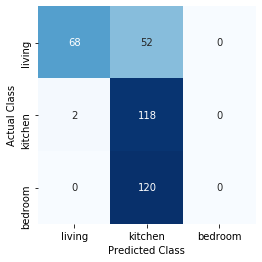

In [35]:
kondo3(X_test, y_test, model)

# ランダムフォレスト

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1000)
clf = clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = clf.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = clf.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.3f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.578


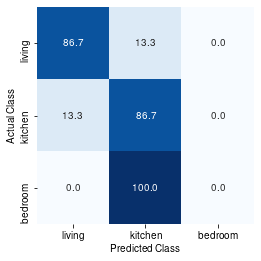

In [42]:
kondo4(X_test, y_test, clf)

# LightGBM

In [38]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=10,
    min_child_samples=20,
    max_depth=15
)
gbm = gbm.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = gbm.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = gbm.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.29


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

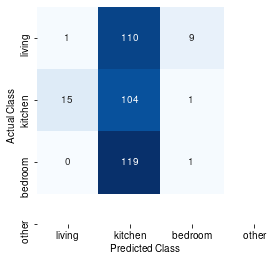

In [39]:
kondo1(X_test, y_test, gbm)

# 訓練データにかたよりがあるのでどうにかする

In [ ]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))

## ダウンサンプリング
一番ラベルの数が少ないのは2なので、0はliv倍、1はkit倍, 2はbed倍してる。(liv,bedは整数)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

positive_count_train = y_train.value_counts()[2] #リビング=0の数

liv=2
kit=2
bed=1
strategy = {0:positive_count_train*liv, 1:positive_count_train*kit, 2:positive_count_train*bed}

rus = RandomUnderSampler(random_state=77, sampling_strategy = strategy)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_resampled.value_counts()

In [ ]:
from sklearn.svm import SVC
model2 = SVC(kernel='linear', random_state=None)

model2 = model.fit(X_resampled, y_resampled)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model2.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model2.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model2)

## リビングの精度が悪い！
テレビは同じなのにどうして…

## テレビの音声だけでテストしてみる

In [ ]:
df_ATJ

In [ ]:
df_ATJ_nonVoice = df_ATJ[df_ATJ["action"] != 1]
df_ATJ_nonVoice

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonVoice.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonVoice["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model)

### テレビをテレビと認識しない…

In [ ]:
df_ATJ_nonTV = df_ATJ[df_ATJ["action"] != 0]
#df_ATJ_nonTV

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonTV.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonTV["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model)